# ISEQL Notebook

## Jupyter Lab and Notebooks

Project Jupyter is an umbrella project centered around the goal of providing tools (and standards) for interactive computing with computational notebooks.
[JupyterLab](https://jupyterlab.readthedocs.io/en/latest/) and [Jupyter Notebook](https://jupyter-notebook.readthedocs.io/en/latest/) are an advanced web-based application for authoring documents that combine live-code with narrative text, equations and visualizations.

This is a Markdown cell to document what you're doing in your notebook. 

You may even include pictures:
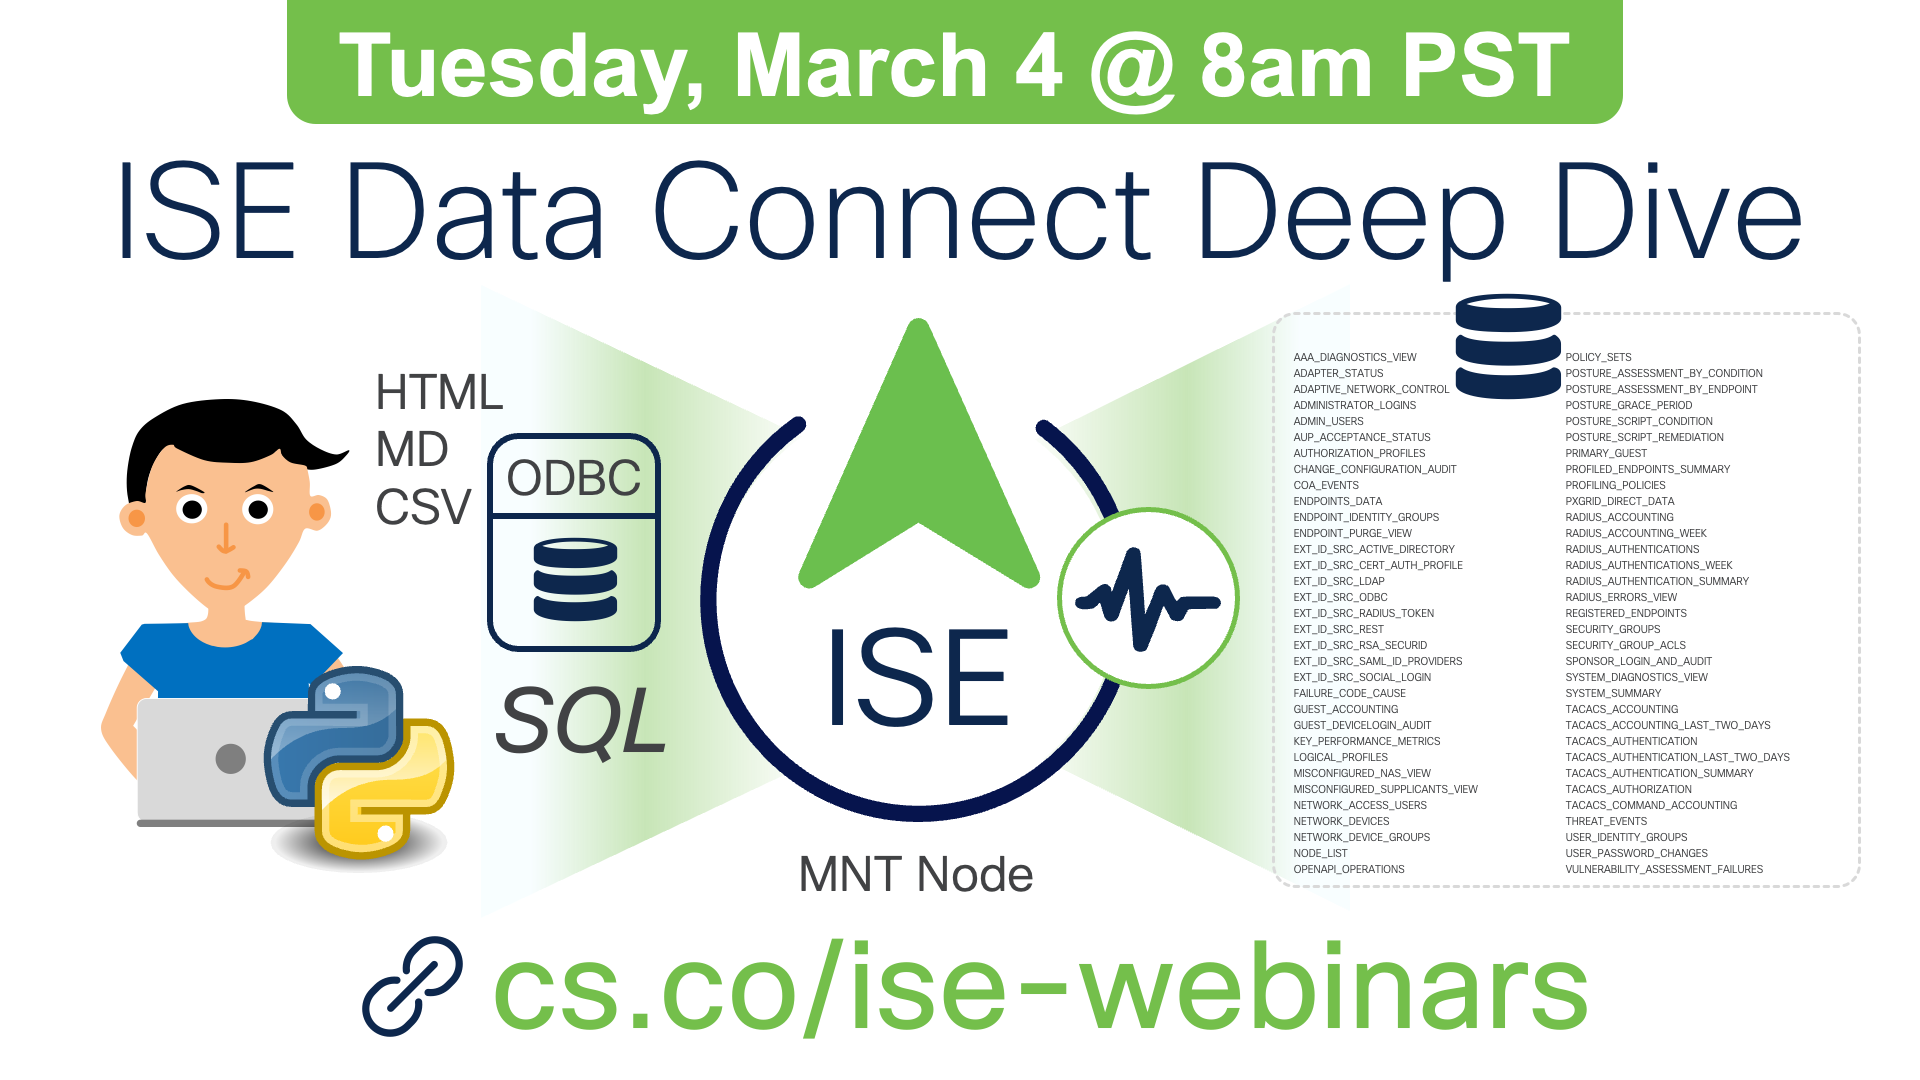


Jupyter has many different ***kernels*** for different programming and scripting languages. Python is the most popular and that is what we will use.

In [ ]:
print("This is a Python code cell")

### Line (`%`) and Cell (`%%`) Magic

Magic Commands are shortcuts that significantly extend a notebook’s capabilities.
There are two kinds of magic:

- `%` : line magic (use this on one line) starts with a percent character
- `%%` : cell magic applies to the whole cell

### `%` Line Magics

| Line Magic    | Description                                               |
| ------------- | --------------------------------------------------------- |
| `!`           | Shell capture  (`myfiles = !ls ~`)                        |
| `%env`        | Get, set, or list environment variables.                  |
| `%gui`        | Enable or disable IPython GUI event loop integration      |
| `%load`       | Load code into the current frontend: `%load file_name.py` |
| `%lsmagic`    | List All Available Magic Commands                         |
| `%matplotlib` | Set up matplotlib to work interactively.                  |
| `%pip`        | Run the pip package manager within the current kernel     |
| `%pwd`        | Return the current working directory path                 |
| `%save`       | Save a set of lines or a macro to a given filename        |
| `%set_env`    | Set environment variables                                 |
| `%sx` or `!!` | Shell execute                                             |
| `%system`     | Shell execute - run shell command and capture output      |


In [ ]:
%load data/SQL/security_groups.sql

In [ ]:
%pwd

In [ ]:
%set_env DEBUG True
%set_env DEBUG=True
%set_env DEBUG=$value

In [ ]:
%set_env ISE_PMNT 172.31.2.21
%set_env ISE_DC_PASSWORD #DataC0nnect
%set_env ISE_VERIFY False

In [ ]:
%env ISE_DC_PASSWORD

### `%%` Cell Magics

| Cell Magic             | Description                                                    |
| ---------------------- | -------------------------------------------------------------- |
| `%%bash`               | Run cells with bash in a subprocess                            |
| `%%capture`            | capture cell stdout, stderr, and IPython’s display() calls     |
| `%%html [--isolated]`  | Render the cell as a block of HTML                             |
| `%%javascript`, `%%js` | Run the cell block of Javascript code                          |
| `%%markdown`, `%%md`   | Render the cell as Markdown text block                         |
| `%%python3`            | Run cells with python3 in a subprocess                         |
| `%%sh`                 | Run cells with sh in a subprocess                              |
| `%%svg`                | Render the cell as an SVG literal                              |
| `%%writefile`          | Write (or append with `-a`) the contents of the cell to a file |


In [ ]:
%%sh
date
date +%s

In [ ]:
! ls -la

In [ ]:
output = ! date +%s

In [ ]:
print(f"output is {output}")

## `oracledb`

OracleDB is the Python package that works as an Open DataBase Connect (ODBC) thin client for Oracle databases.

In [ ]:
%pip install -r requirements.txt

In [ ]:
import csv
import oracledb
import os
import ssl
import sys


ISE_PMNT = "172.31.2.21"
ISE_DC_PORT = 2484  # Data Connect port
ISE_DC_SID = "cpm10"  # Data Connect service name identifier
ISE_DC_USERNAME = "dataconnect"  # Data Connect username
ISE_DC_PASSWORD = "#DataC0nnect"  # Data Connect password

insecure = os.environ.get("ISE_VERIFY", "False")[0:1].lower() in ["f", "n"]
ssl_context = ssl.SSLContext(ssl.PROTOCOL_TLS_CLIENT)
if insecure:
    ssl_context.check_hostname = False  # required before setting verify_mode == ssl.CERT_NONE
    ssl_context.verify_mode = ssl.CERT_NONE  # any cert is accepted; validation errors are ignored

odbc_params = oracledb.ConnectParams(
    protocol="tcps",  # tcp "secure" with TLS
    host=ISE_PMNT,  # hostname or IP address of database host machine
    port=ISE_DC_PORT,  # Oracle Default: 1521
    service_name=ISE_DC_SID,
    user=ISE_DC_USERNAME,
    password=ISE_DC_PASSWORD,
    retry_count=3,  # connection attempts retries before being terminated. Default: 0
    retry_delay=3,  # seconds to wait before a new connection attempt. Default: 0
    ssl_context=ssl_context,  # an SSLContext object which is used for connecting to the database using TLS
    ssl_server_dn_match=False, # boolean indicating if the server certificate distinguished name (DN) should be matched. Default: True
    # ssl_server_cert_dn=False # the distinguished name (DN), which should be matched with the server
    # wallet_location=DIR_EWALLET, # the directory containing the PEM-encoded wallet file, ewallet.pem
)


def query(params, query: str = None):
    with oracledb.connect(params=params) as connection:
        with connection.cursor() as cursor:
            cursor.execute(query)

            # Get header names from cursor.description: [ (name, type_code, display_size, internal_size, precision, scale, null_ok), ... ]
            headers = [f"{i[0]}".lower() for i in cursor.description]
            # Use CSV by default to stream results without large memory buffering
            writer = csv.writer(sys.stdout, quoting=0, skipinitialspace=True)
            writer.writerow(headers)
            while True:
                rows = cursor.fetchmany()  # use default Cursor.arraysize
                if not rows:
                    break
                writer.writerows(rows)

Run a query using the specified ODBC client parameters and you will get the results as CSV (comma-separated values):

In [ ]:
query(odbc_params, "SELECT * FROM node_list")

## `iseql.py`

In [ ]:
! iseql.py --help

In [ ]:
! iseql.py -i "SELECT * FROM node_list"

### Output Formats

The default format is CSV (comma-separated value) because it is compact, fast, and does not require buffering the output in memory to format it. However, with many columns and varying widths, it may be difficult to visually parse.

The `-f table` format is much easier to read but may take a lot more space with padding for column alignment:

In [ ]:
! iseql.py -i "SELECT * FROM node_list" -f table

JSON is a very popular format but without indenting it can be difficult for a human to read in a single continuous line:

In [ ]:
! iseql.py -i "SELECT * FROM node_list" -f json

For this reason, you the `-f pretty` option will pretty-print your JSON with a compact 2-space indent:

In [ ]:
! iseql.py -i "SELECT * FROM node_list" -f pretty

YAML has a similar structure to JSON but it is cleaner without the double-quotes and brackets:

In [ ]:
! iseql.py -i "SELECT * FROM node_list" -f yaml

`iseql.py` can also read an SQL filepath (`*.sql`) and run the query:

In [ ]:
! iseql.py -i data/SQL/radius_auths_by_policy.sql -f table

In [ ]:
! cat data/SQL/radius_auths_by_policy.sql

### Self-Signed Certificates

If you have a self-signed or expired certificate, the database connection may fail after a timeout:

In [ ]:
%env ISE_VERIFY True
! iseql.py "SELECT * FROM node_list"

Use the `-i` or `--insecure` flag to skip certificate validate and allow self-signed certificates:

In [ ]:
! iseql.py --insecure "SELECT * FROM node_list"

In [ ]:
%env ISE_VERIFY False

In [ ]:
! iseql.py "SELECT * FROM node_list"

### Performance

ISEQL also includes a `-t` or` --timer` option to measure the time to run a query. 

Be careful with queries of large tables like `radius_authentications` and `radius_accounting`! Downloading 10,000+ rows will take many seconds and 3X or more with some "pretty" formats. A quick performance time test using the `-t/timer` option to retrieve 10,000 RADIUS Accounting rows (`iseql.py "SELECT * FROM radius_accounting FETCH FIRST 10000 ROWS ONLY" -tf csv`):

| Format          | Time (seconds) |
|-----------------|----------------|
| `csv` (default) |            3.9 |
| `json`          |            4.7 |
| `line`          |            4.9 |
| `pretty`        |            4.9 |
| `text`          |           11.8 |
| `table`         |           11.9 |
| `markdown`      |           12.0 |
| `yaml`          |           29.0 |


In [ ]:
! iseql.py --timer "SELECT COUNT(*) AS total FROM radius_accounting"

The default CSV format will stream the data instantly:

In [ ]:
! iseql.py --timer "SELECT * FROM radius_accounting FETCH FIRST 5000 ROWS ONLY"

However other formats will buffer the output before showing it making you think your quiery is not working or osomething is wrong :

In [ ]:
! iseql.py --timer "SELECT * FROM radius_accounting FETCH FIRST 5000 ROWS ONLY" -f table

## SQL

### ISE Data Connect Tables

Query the database for the list of all ISE Data Connect tables (views):

In [ ]:
%%writefile data/SQL/dc_views.sql
--
-- Lists all available table views in ISE Data Connect 
--
SELECT view_name
FROM user_views
ORDER BY view_name ASC

In [ ]:
! iseql.py -i data/SQL/dc_views.sql -f table

### SQL is Case Insensitive

SQL queries are ***case-insensitive***. These are all the same to SQL:

```sql
select timestamp, username, calling_station_id, authorization_profiles from radius_authentications fetch first 10 rows only
SELECT TIMESTAMP, USERNAME, CALLING_STATION_ID, AUTHORIZATION_PROFILES FROM RADIUS_AUTHENTICATIONS FETCH FIRST 10 ROWS ONLY
Select Timestamp, Username, Calling_Station_Id, Authorization_Profiles From Radius_Authentications Fetch First 10 Rows Only
```

Using UPPERCASE or lowercase keywords is a stylistic choice. This notebook uses UPPERCASE keywords and lowercase values.

> Note: Conditional values when filtering are ***case-sensitive***!

In [ ]:
! iseql.py -i "select timestamp, username, calling_station_id, authorization_profiles from radius_authentications fetch first 10 rows only" -f table

In [ ]:
%%writefile data/SQL/dc_table_columns.sql
--
-- Shows all columns definitions in the specified ISE Data Connect table.
-- This is similar to doing a `SELECT * FROM {table_name}
--
SELECT table_name, column_name
FROM all_tab_columns
WHERE table_name = 'radius_authentications'
ORDER BY table_name ASC, column_name ASC

In [ ]:
! iseql.py -i data/SQL/dc_table_columns.sql -f table

### Selections (`SELECT`)


Use `SELECT` to choose the columns you want and in what order from left to right.

Use `AS` to *rename* the output column name.

In [ ]:
! iseql.py -i "SELECT * FROM radius_authentications FETCH FIRST 10 ROWS ONLY" -f table

In [ ]:
! iseql.py -i "SELECT * FROM radius_authentications FETCH FIRST 10 ROWS ONLY" -f table

In [ ]:
! iseql.py -i "SELECT * FROM radius_accounting FETCH FIRST 10 ROWS ONLY" -f table

In [ ]:
! iseql.py -i "SELECT * FROM endpoints_data FETCH FIRST 10 ROWS ONLY" -f table

In [ ]:
%load data/SQL/endpoints_data.sql

In [ ]:
! iseql.py -i data/SQL/endpoints_data_custom.sql -f table

### Limit (`OFFSET` and `FETCH`)

The use of `OFFSET` and `FETCH` allow for paging large data sets.

Syntax:

```sql
[ OFFSET offset ROWS]
 FETCH  NEXT [  row_count | percent PERCENT  ] ROWS  [ ONLY | WITH TIES ] 
```

Examples:

```sql
FETCH NEXT 1 ROWS
FETCH FIRST 1 ROW

FETCH NEXT 5 ROWS ONLY
FETCH FIRST 5 PERCENT ROWS ONLY

OFFSET 100 ROWS 
FETCH NEXT 100 ROWS ONLY
```

In [ ]:
! iseql.py -i "SELECT * FROM radius_accounting FETCH NEXT 10 ROWS ONLY" -f table

### Timestamps

Format a date using `TO_CHAR(date, format)`.

`TRUNC()` function returns a `DATE` value truncated to a specified unit (`YYYY`, `Q`, `MM`, `DD`, `HH`, `HH24`, `MI`, etc.), setting the time to `00:00:00` by default.


In [ ]:
%%writefile data/SQL/timestamps_test.sql
--
-- Show a practical view of the radius_accounting table.
--
SELECT
    timestamp AS timestamp,
    TO_CHAR(timestamp, 'YYYY-MM-DD HH24:MI:SS.FF3') AS "YYYY-MM-DD hh:mm:ss.fff", -- milliseconds
    TO_CHAR(timestamp, 'YYYY-MM-DD HH24:MI:SS') AS "YYYY-MM-DD hh:mm:ss", -- seconds
    TO_CHAR(timestamp, 'YYYY-MM-DD') AS "YYYY-MM-DD",
    TRUNC(timestamp, 'DD') AS trunc_to_dd,
    TRUNC(timestamp, 'MI') AS trunc_to_mi,
    acct_session_id AS session_id, -- Unique numeric string identifying the server session
    acct_status_type AS status, -- Specifies whether accounting packet starts or stops a bridging, routing, or terminal server session.
    calling_station_id AS mac
FROM radius_accounting
WHERE timestamp > sysdate - INTERVAL '1' HOUR -- last N hours
-- WHERE timestamp > sysdate - INTERVAL '1' DAY -- last N days
ORDER BY timestamp ASC -- first/oldest records
FETCH NEXT 30 ROWS ONLY -- limit default number of rows returned for large datasets


In [ ]:
! iseql.py -i data/SQL/timestamps_test.sql -f table

### Functions

COUNT(column)

In [ ]:
%%sh
iseql.py -i "
SELECT
    TO_CHAR(timestamp, 'YYYY-MM-DD') AS timestamp, -- per day (2024-12-01)
    COUNT(CASE WHEN acct_status_type = 'Start' THEN 1 END) AS starts,
    COUNT(CASE WHEN acct_status_type = 'Stop' THEN 1 END) AS stops,
    COUNT(CASE WHEN acct_status_type = 'Interim-Update' THEN 1 END) AS interims,
    COUNT(CASE WHEN syslog_message_code > '3002' THEN 1 END) AS others,
    COUNT(*) AS total -- total
FROM radius_accounting
GROUP BY TO_CHAR(timestamp, 'YYYY-MM-DD') -- per day
ORDER BY timestamp ASC -- first/oldest records
" -f table

Use `NVL(column, default)` to assign a default value instead of a blank (null) value:

In [ ]:
%%sh
iseql.py -i "
SELECT
    acct_session_id,
    CASE WHEN MAX(syslog_message_code) = 3001 THEN '□' WHEN (MAX(timestamp) < (SYSDATE - 1)) THEN '!' WHEN MAX(syslog_message_code) = '3002' THEN '⧖'  ELSE '▷' END AS ℹ,
    TO_CHAR(MIN(timestamp), 'YYYY-MM-DD HH24:MI:SS') AS started, -- drop fractional seconds
    TO_CHAR(MAX(timestamp), 'YYYY-MM-DD HH24:MI:SS') AS stopped, -- drop fractional seconds
    MAX(syslog_message_code) AS code, -- 3000=Acct-Start, 3001=Acct-Stop, 3002=Interim-Update, 3003=Acct-On, 3004=Acct-Off
    COUNT(timestamp) AS num, -- total accounting updates
    MAX(acct_session_time) AS length, -- time (seconds) for which the session has been Started
    NVL(MAX(acct_session_time), 0) AS length0, -- time (seconds) for which the session has been Started
    MAX(calling_station_id) AS mac -- endpoint MAC address (00:00:00:00:00:00)
FROM radius_accounting
WHERE syslog_message_code != 3003 AND syslog_message_code != 3004 -- ignore Accounting-On/Off messages
  AND timestamp > sysdate - INTERVAL '2' HOUR -- last N hours
GROUP BY acct_session_id
ORDER BY MIN(timestamp) ASC -- first/oldest records
" -f table

### String Length, Concatenation, and Truncation

Find a string's length:

```
LENGTH(column)
```

Use a double vertical bar for concatenating strings:

```sql
string1 || string2
```

Slice a string from `first` to `last` characters:

```sql
SUBSTR(column, first, last)
```


Use `LENGTH()` and `SUBSTR()` to truncate text to a reasonable length:

In [ ]:
! iseql.py data/SQL/failure_code_cause.sql

In [ ]:
%%sh
iseql.py -i "
SELECT
  -- failure_code, -- the failure code
  CASE WHEN LENGTH(failure_code) > 70 THEN SUBSTR(failure_code, 1, 69) || '...' ELSE failure_code END AS failure_code, -- trim verbose messages
  -- failure_cause -- the failure cause
  CASE WHEN LENGTH(failure_cause) > 70 THEN SUBSTR(failure_cause, 1, 69) || '...' ELSE failure_cause END AS failure_cause -- trim verbose messages
FROM failure_code_cause
ORDER BY failure_code ASC
" -f table

In [ ]:
! iseql.py data/SQL/system_summary_last_hour.sql -f table

### String Conditionals

```sql
CASE WHEN condition THEN value1 
CASE WHEN condition THEN value2
...
ELSE default_value
END [AS column_name]
``` 

In [ ]:
# %load data/SQL/endpoints_random.sql
--
-- endpoints_random
--
SELECT
  TO_CHAR(create_time, 'YYYY-MM-DD HH24:MI:SS') AS created, -- time when record added; drop fractional seconds
  mac_address, -- endpoint MAC address
  CASE WHEN REGEXP_LIKE(mac_address, '^.[26AE].*', 'i') THEN SUBSTR(mac_address, 2, 1) ELSE '✕' END AS random, -- random MAC feature column ✔|✕
  endpoint_ip, -- the IP address of the endpoint
  endpoint_policy, -- ⚡ endpoint profile classification
  static_assignment AS is_static, -- ⚡ the endpoint static assignment status
  static_group_assignment AS static_group, -- ⚡ endpoint statically assigned to user ID group
  version -- ⧗ the version
FROM endpoints_data
ORDER BY mac_address ASC


In [ ]:
! iseql.py data/SQL/endpoints_random.sql -f table

### Filtering (`WHERE`, `HAVING`)

| **Operator**                   | **Description**                                                                             |
| ------------------------------ | ------------------------------------------------------------------------------------------- |
| **Comparison Operators**       |                                                                                             |
| =                              | Equality                                                                                    |
| !=,<>                          | Inequality                                                                                  |
| >                              | Greater than                                                                                |
| <                              | Less than                                                                                   |
| >=                             | Greater than or equal to                                                                    |
| <=                             | Less than or equal to                                                                       |
| **Set Operators**              |                                                                                             |
| `[NOT] IN `                    | Equal to any value in a list of values, or not                                              |
| `ANY` / `SOME` / `ALL`         | Compare to list or subquery; must be preceded by another operator                           |
| **Range Operators**            |                                                                                             |
| `[NOT] BETWEEN` *n* `AND` _m_  | Checks if a value is within a specified range (inclusive). Same as [Not] >= n AND <= y      |
| `[NOT] EXISTS `                | Return true if the subquery returns at least one row                                        |
| `IS [NOT] NULL`                | NULL test                                                                                   |
| `LIKE` _str_                   | % is a wildcard operator                                                                    |
| **Logical Operators**          |                                                                                             |
| `AND`                          | Combines two conditions and returns true if both conditions are true                        |
| `OR`                           | Combines two conditions and returns true if either condition is true                        |
| **Pattern Matching Operators** |                                                                                             |
| `LIKE` _pattern_               | Searches for pattern in a column. Use `%` for wildcard characters and `_` for a single char |
| `REGEXP_LIKE(str, pattern, options)` | Searches for pattern in a column using a regular expression |


In [ ]:
! iseql.py data/SQL/radius_acct_by_session_id.sql -f table

In [ ]:
! iseql.py "SELECT * FROM network_devices WHERE name LIKE 'thomas%'" -f table

In [ ]:
WHERE acct_status_type = 'Start' -- 3000=Start, 3001=Stop, 3002=Interim-Update, 3003=Accounting-On, 3004=Accounting-Off
WHERE syslog_message_code = '3001' -- 3000=Start, 3001=Stop, 3002=Interim-Update, 3003=Accounting-On, 3004=Accounting-Off
WHERE acct_status_type = 'Stop'
WHERE stopped != 3001
WHERE username = 'thomas'
WHERE device_name = 'thomas-mr46-2nl6'
WHERE acct_session_time < (60*60) -- sessions < 1 hour
WHERE acct_session_time > 3700 -- > sessions 1 hour
WHERE acct_session_time > (60*60*24) -- sessions > 1 day
WHERE acct_session_time > (60*60*24*3) -- sessions > 3 days
WHERE timestamp > sysdate - INTERVAL '10' SECOND -- last N seconds
WHERE timestamp > sysdate - INTERVAL '1' MINUTE  -- last N minutes
WHERE timestamp > sysdate - INTERVAL '1' HOUR -- last N hours
WHERE timestamp > sysdate - INTERVAL '1' DAY -- last N days
WHERE TO_CHAR(timestamp, 'YYYY-MM-DD') = '2024-11-01' -- match a timestamp by day
WHERE TO_CHAR(timestamp, 'YYYY-MM-DD HH24:MI:SS') = '2024-11-01 00:08:27' -- match a timestamp (YYYY-MM-DD HH24:MI:SS.ffffff)
WHERE TRUNC(timestamp) = TRUNC(SYSDATE) -- today
WHERE TRUNC(timestamp) = '01-NOV-24' -- Specific day (trunc format)
WHERE TRUNC(timestamp, 'HH24') = TRUNC(SYSDATE, 'HH24') -- sessions this hour
WHERE TRUNC(timestamp, 'DD') = '20-OCT-24' -- Specific DoM Format: 'DD-MMM-YY HH.MM.SS.mmmmmmmmm AM|PM'
WHERE timestamp > '01-NOV-24 08.00.00.000 AM' -- Format: 'DD-MMM-YY HH.MM.SS.mmmmmmmmm AM|PM'
WHERE timestamp > TIMESTAMP '2024-11-01 19:39:00' -- after a timestamp
WHERE timestamp > TIMESTAMP '2024-11-01 19:00:00' AND timestamp < TIMESTAMP '2024-11-01 20:00:00' -- time window
WHERE timestamp BETWEEN Date '2024-11-01' and Date '2024-11-02' -- exclusive of end date

In [ ]:
%%sh
iseql.py -i "
SELECT * FROM radius_accounting 
WHERE username = 'thomas'
  AND device_name = 'thomas-mr46-2nl6'
  AND timestamp > sysdate - INTERVAL '12' HOUR -- last N hours
" -f table

### Sorting (`ORDER BY`)


Order rows in either ascending or descending order by one or more columns

```sql
ORDER BY column_1 [ASC | DESC] [NULLS FIRST | NULLS LAST]
```

In [ ]:
! iseql.py "SELECT * FROM radius_accounting ORDER BY timestamp ASC FETCH NEXT 10 ROWS ONLY" -f table

In [ ]:
! iseql.py "SELECT * FROM radius_accounting ORDER BY response_time DESC FETCH NEXT 10 ROWS ONLY" -f table

### Aggregation (`GROUP BY`)


The `GROUP BY` clause is used in a `SELECT` statement to group rows into a set of summary rows by values of columns or expressions. 

The `GROUP BY` clause returns one row per group.

The aggregate function returns the summary information per group.

You must specify how every attribute's values are summarized: `AVG()`, `COUNT()`, `MAX()`, `MIN()` and`SUM()`.

In [ ]:
# %load data/SQL/radius_auths_failure_reason_counts.sql
--
-- RADIUS Authentications by Failure Reason Counts
--

SELECT
  COUNT(*) as total,
  calling_station_id AS mac,
  username AS username,
  failure_reason
FROM radius_authentications
WHERE failure_reason IS NOT NULL
GROUP BY failure_reason, calling_station_id, username
ORDER BY total DESC


In [ ]:
! iseql.py data/SQL/radius_auths_failure_reason.sql -f table

In [ ]:
# %load data/SQL/radius_acct_counts_by_day.sql
--
-- Summarize all Cisco ISE RADIUS Accounting events per day.
-- You may also do this per hour/minute/second by changing the timestamp format and GROUP BY statement.
--
SELECT
    COUNT(CASE WHEN acct_status_type = 'Start' THEN 1 END) AS starts,
    COUNT(CASE WHEN acct_status_type = 'Stop' THEN 1 END) AS stops,
    CASE 
        WHEN COUNT(CASE WHEN acct_status_type = 'Start' THEN 1 END) = 0 THEN 0 
        ELSE ROUND(COUNT(CASE WHEN acct_status_type = 'Stop' THEN 1 END) / COUNT(CASE WHEN acct_status_type = 'Start' THEN 1 END), 2)
    END AS stop_to_start,
    COUNT(CASE WHEN acct_status_type = 'Interim-Update' THEN 1 END) AS interims,
    ROUND(COUNT(CASE WHEN acct_status_type = 'Interim-Update' THEN 1 END) / COUNT(*), 2) AS interim_to_total,
    COUNT(CASE WHEN syslog_message_code > '3002' THEN 1 END) AS others,
    COUNT(*) AS total -- total
FROM radius_accounting
GROUP BY TO_CHAR(timestamp, 'YYYY-MM-DD') -- per day
ORDER BY timestamp ASC -- first/oldest records


In [ ]:
! iseql.py data/SQL/radius_acct_counts_by_day.sql -f table

In [ ]:
-- %load data/SQL/radius_auths_by_policy.sql
--
-- RADIUS Authentications by Policy
--
SELECT
    policy_set_name AS policy_set, -- 
    authentication_method AS authn_method, -- 
    authentication_protocol AS authn_protocol, -- 
    NVL(authorization_rule, '-') AS authz_rule, -- 
    NVL(authorization_profiles, 'ACCESS-REJECT') AS authz_profile, -- 
    MAX(security_group) AS security_group, -- 
    TO_CHAR(AVG(response_time), '9999999') || 'ms' AS rt_avg, -- avg response time
    TO_CHAR(MAX(response_time), '9999999') || 'ms' AS rt_max, -- max response time
    COUNT(CASE WHEN passed = 'Pass' THEN 1 END) AS passed,
    COUNT(CASE WHEN passed = 'Fail' THEN 1 END) AS failed,
    COUNT(timestamp) AS total,
    TO_CHAR(ROUND( (COUNT(CASE WHEN passed = 'Fail' THEN 1 END) / (COUNT(CASE WHEN passed = 'Pass' THEN 1 END) + COUNT(CASE WHEN passed = 'Fail' THEN 1 END)) * 100), 0), 'FM999') || '%' AS fail_pct
FROM radius_authentications
WHERE timestamp > sysdate - INTERVAL '30' DAY -- last N days
GROUP BY policy_set_name, access_service, authentication_method, authentication_protocol, authorization_rule, authorization_profiles
ORDER BY policy_set_name ASC, total DESC 


In [ ]:
! iseql.py data/SQL/radius_auths_by_policy.sql -f table

### Calculations


`AVG()`, `COUNT()`, `MAX()`, `MIN()` and`SUM()`.

In [ ]:
! iseql.py -i "SELECT count(mac_address) as total FROM endpoints_data"

In [ ]:
! iseql.py -i "SELECT count(timestamp) as total FROM radius_accounting"

In [ ]:
%%writefile data/SQL/radius_acct_starts.sql

SELECT
    TO_CHAR(timestamp, 'YYYY-MM-DD HH24:') || '00:00' AS timestamp, -- per hour
    COUNT(acct_status_type) AS starts
FROM radius_accounting
WHERE acct_status_type = 'Start'
GROUP BY TO_CHAR(timestamp, 'YYYY-MM-DD HH24:') || '00:00' -- per hour
ORDER BY timestamp ASC -- first/oldest records

In [ ]:
! iseql.py -i data/SQL/radius_acct_starts.sql  -f table

In [ ]:
! iseql.py -i data/SQL/radius_auths_by_policy.sql  -f table

## Sessions From RADIUS Accounting


Many columns are irrelevant for session tracking or have empty values

In [ ]:
! iseql.py -i "SELECT * FROM radius_accounting FETCH NEXT 20 ROWS ONLY" -f table

Select the columns you think are relevant:

In [ ]:
%%writefile test.sql

SELECT
  timestamp,
  acct_session_id,
  syslog_message_code,
  acct_status_type,
  acct_session_time,
  acct_terminate_cause,
  calling_station_id,
  username,
  device_name,
  nas_port,
  ise_node
FROM radius_accounting
ORDER BY timestamp
FETCH NEXT 20 ROWS ONLY

In [ ]:
! iseql.py -i test.sql -f table

Order by session_id, timestamp to group session events

In [ ]:
%%writefile test.sql

SELECT
  timestamp, 
  acct_session_id,
  syslog_message_code,
  acct_status_type,
  acct_session_time,
  calling_station_id
  -- username,
  -- device_name,
  -- nas_port,
  -- ise_node
FROM radius_accounting
ORDER BY acct_session_id, timestamp ASC
FETCH NEXT 20 ROWS ONLY


In [ ]:
! iseql.py -i test.sql -f table

Drop columns, drop fractional seconds, shorten headers:

In [ ]:
%%writefile test.sql

SELECT
  TO_CHAR(timestamp, 'YYYY-MM-DD HH24:MI:SS') AS timestamp, -- drop fractional seconds 
  acct_session_id AS session_id, 
  syslog_message_code as code,
  acct_status_type AS type,
  acct_session_time AS time,
  calling_station_id AS mac
FROM radius_accounting
ORDER BY acct_session_id, timestamp ASC
FETCH NEXT 20 ROWS ONLY


In [ ]:
! iseql.py -i test.sql -f table

Event Types

syslog_message_code | acct_status_type
------------------- | ----------------
               3000 | Start
               3001 | Stop
               3002 | Interim-Update
               3003 | Accounting-On
               3004 | Accounting-Off


In [ ]:
%%writefile test.sql

SELECT COUNT(*), syslog_message_code,  MAX(acct_status_type)
FROM radius_accounting
GROUP BY syslog_message_code
ORDER BY syslog_message_code ASC


In [ ]:
! iseql.py -i test.sql -f table

Sesion Status Feature Column Icon

In [ ]:
%%writefile test.sql

SELECT
  TO_CHAR(timestamp, 'YYYY-MM-DD HH24:MI:SS') AS timestamp, -- drop fractional seconds 
  acct_session_id AS session_id, 
  CASE
    WHEN syslog_message_code = 3000 THEN '▷' 
    WHEN syslog_message_code = 3001 THEN '□'
    WHEN syslog_message_code = 3002 THEN '⧖'
    WHEN syslog_message_code = 3003 THEN '⏻'
    WHEN syslog_message_code = 3004 THEN '⏼'
  ELSE '?' END AS status, -- status type feature column
  syslog_message_code as code,
  acct_status_type AS type,
  acct_session_time AS time,
  calling_station_id AS mac
FROM radius_accounting
ORDER BY acct_session_id, timestamp ASC
FETCH NEXT 20 ROWS ONLY


In [ ]:
! iseql.py -i test.sql -f table

Group by acct_session_id

In [ ]:
%%writefile test.sql

SELECT
  acct_session_id,
  COUNT(*) AS logs,
  CASE
    WHEN MAX(syslog_message_code) = 3000 THEN '▷' 
    WHEN MAX(syslog_message_code) = 3001 THEN '□'
    WHEN MAX(syslog_message_code) = 3002 THEN '⧖'
    WHEN MAX(syslog_message_code) = 3003 THEN '⏻'
    WHEN MAX(syslog_message_code) = 3004 THEN '⏼'
  ELSE '?' END AS status, -- status type feature column
  TO_CHAR(MIN(timestamp), 'YYYY-MM-DD HH24:MI:SS') AS started,
  MIN(syslog_message_code) AS code_min,
  MAX(syslog_message_code) AS code_max,
  TO_CHAR(MAX(timestamp), 'YYYY-MM-DD HH24:MI:SS') AS updated,
  MAX(calling_station_id) AS mac,
  MAX(acct_session_time) as session_time
FROM radius_accounting
WHERE timestamp > sysdate - INTERVAL '1' DAY -- last N days
GROUP BY acct_session_id
ORDER BY started DESC -- newest/latest first
FETCH NEXT 20 ROWS ONLY


In [ ]:
! iseql.py -i test.sql -f table

Feature Column: Session State

All Active RADIUS Accounting sessions consume a license until a RADIUS Accounting Stop is received or the session is cleared in ISE.
A RADIUS session is Active/Started if:
  - there is a RADIUS Accounting Start record (syslog_message_code = 3000 OR acct_status_type = 'Start') with an acct_session_id
  - the acct_session_id does not have a corresponding Stop record (syslog_message_code = 3001 OR acct_status_type = 'Stop')
  - the last update is < 5 days old

  ⓘ there may 0 or more Interim-Updates (syslog_message_code = 3002 or acct_status_type = Interim-Update) to maintain a session

⚠ If a device is [unintentionally] powered off or accounting is mis/unconfigured, it's sessions' may become stale in ISE.

ⓘ RADIUS Accounting sessions without updates every 24 hours are generally considered as 'ghosted' 👻

ⓘ ISE clears any session after five days of inactivity (no further RADIUS Accounting updates for that acct_session_id).

ⓘ RADIUS Accounting Interim-Updates may contain IPv4/v6 address changes for the given sessions

ⓘ Cisco WLC uses an Accounting-Stop with a 'nas-update=true' attribute to identify a session in a roaming state.
   When ISE sees this attribute, the session is not deleted in ISE to avoid reauthentication.
   If roaming fails, ISE clears the session after five days of inactivity.


In [ ]:
%%writefile test.sql

SELECT
  acct_session_id,
  COUNT(*) AS logs,
  CASE
    WHEN MAX(syslog_message_code) = 3001 THEN '□' -- stopped
    WHEN (MAX(timestamp) < (SYSDATE - 5)) THEN '⛝' -- expired (□ ⊠ ⛞) by ISE after 5 days from last update
    WHEN (MAX(timestamp) < (SYSDATE - 1)) THEN '∅' -- ghosted (! ◌ ⌀ ⦰ ⍉ ⚠) 
    WHEN MAX(syslog_message_code) = '3002' THEN '⧖' -- interim
    WHEN MAX(syslog_message_code) = '3000' THEN '▷' -- started
  ELSE '?' END AS state, -- session state feature column
  TO_CHAR(MIN(timestamp), 'YYYY-MM-DD HH24:MI:SS') AS started,
  TO_CHAR(MAX(timestamp), 'YYYY-MM-DD HH24:MI:SS') AS updated,
  MAX(syslog_message_code) AS code_max,
  MAX(acct_session_time) as session_time, -- reported session length (seconds)
  MAX(calling_station_id) AS mac
FROM radius_accounting
WHERE timestamp > sysdate - INTERVAL '4' DAY -- last N days
  AND syslog_message_code < 3003 -- ignore Accounting-On/Off messages
GROUP BY acct_session_id
ORDER BY started DESC

In [ ]:
! iseql.py -i test.sql -f table

### ISE Active Sessions
Find all sessions with state IN ('∅','⧖','▷') with unique MACs sorted by last updated

In [ ]:
%%writefile test.sql

SELECT *
FROM (
  SELECT
    acct_session_id,
    COUNT(*) AS logs,
    CASE
      WHEN MAX(syslog_message_code) = 3001 THEN '□' -- stopped
      WHEN (MAX(timestamp) < (SYSDATE - 4)) THEN '⛝' -- expired (□ ⊠ ⛞) by ISE after 5 days from last update
      WHEN (MAX(timestamp) < (SYSDATE - 1)) THEN '∅' -- ghosted (! ◌ ⌀ ⦰ ⍉ ⚠) 
      WHEN MAX(syslog_message_code) = '3002' THEN '⧖' -- interim
      WHEN MAX(syslog_message_code) = '3000' THEN '▷' -- started
    ELSE '?' END AS state, -- session state feature column
    TO_CHAR(MIN(timestamp), 'YYYY-MM-DD HH24:MI:SS') AS started,
    TO_CHAR(MAX(timestamp), 'YYYY-MM-DD HH24:MI:SS') AS updated,
    MAX(syslog_message_code) AS code_max,
    NVL(MAX(acct_session_time), 0) as session_time, -- reported session length (seconds)
    MAX(calling_station_id) AS mac
  FROM radius_accounting
  WHERE timestamp > sysdate - INTERVAL '4' DAY -- last N days
    AND syslog_message_code < 3003 -- ignore Accounting-On/Off messages
  GROUP BY acct_session_id
  ORDER BY started DESC
)
WHERE state IN ('∅','⧖','▷')
ORDER BY updated ASC, mac ASC


In [ ]:
! iseql.py -i test.sql -f table

## ISE Frequently Asked Queries (FAQs)

## Devices

### Devices Last Auth

Show network devices by their last authentication timestamp to identify devices for removal from ISE.

In [ ]:
! iseql.py -i data/SQL/devices_last_auth.sql -f table

### Devices' Last Authentication

Show the last RADIUS authentication per network device. Optionally filter for >N days or more. 

In [ ]:
! iseql.py -i data/SQL/devices_last_auth.sql -f table

## Sessions

### RADIUS Accounting Counts by Day

Count all of the RADIUS Accounting Events (Starts, Stops, Interims, Others, Total) per Day

In [ ]:
! iseql.py -i data/SQL/radius_acct_counts_by_day.sql -f table

### RADIUS Accounting by Device

Discover high interim event counts from any devices.

In [ ]:
! iseql.py -i data/SQL/radius_acct_counts_by_device.sql -f table

In [ ]:
! iseql.py -i data/SQL/radius_acct_stops.sql -f table

### RADIUS Accounting Sessions

Summarize all RADIUS Accounting sessions by `acct_session_id` with their `started` and update time along with an icon for the current session state in the `ℹ` column:  `▷` started, `□` stopped, `⧖` interim, `!` ghosted.

In [ ]:
! iseql.py -i data/SQL/radius_acct_sessions.sql -f table

### RADIUS Accounting by Session ID

Show all RADIUS Accounting events for a specified `acct_session_id`

In [ ]:
! iseql.py -i data/SQL/radius_acct_by_session_id.sql -f table

## Endpoints

### Endpoints Data

In [ ]:
! iseql.py -i data/SQL/endpoints_data.sql -f table

### Endpoints

Customized endpoints_data with added feature columns for random MAC, endpoint age, and activity.

In [ ]:
! iseql.py -i data/SQL/endpoints.sql -f table

### Endpoints Last Auth

In [ ]:
! iseql.py -i data/SQL/endpoints_last_auth.sql -f table

### Endpoints Profile Unknown

In [ ]:
! iseql.py -i data/SQL/endpoints_profile_unknown.sql -f table

## Failures

### RADIUS Authentication Failure Reasons

In [ ]:
! iseql.py -i data/SQL/radius_auths_failure_reason_counts.sql -f table

### Password Failures

In [ ]:
! iseql.py -i data/SQL/radius_auths_password_failures.sql -f table

## Users

### RADIUS Authentication Failures by Username

In [ ]:
! iseql.py -i data/SQL/radius_auths_pass_fail_counts_by_username.sql -f table

### Subject Not Found (Unknown User)

In [ ]:
! iseql.py -i data/SQL/radius_auths_subject_not_found.sql -f table